## Optimization of the Life Insurance Underwriting Process Using Recommender Systems

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, precision, recall, reciprocal_rank, discounted_cumulative_gain
np.random.seed(20)

In [2]:
## to normalize columns
def norm(series):
    a = min(series)
    b = max(series)
    return [(x - a) / (b - a) for x in series]

## Data Simulation

In [3]:
## Creating columns
n = 10000
## Random policy numbers
startPolicyNo = st.randint.rvs(0,100000)
## Item IDs
insuredID = [str(startPolicyNo + i) for i in range(n)]
## 0 male 1 female
age = [st.uniform.rvs(20,80) for i in range(n)]
gender = [1 if st.bernoulli.rvs(0.5) else 0 for i in range(n)]
weight = [st.norm.rvs(loc = 200, scale = 25) if gender[i] == "0" else st.norm.rvs(loc = 170, scale = 25) for i in range(n)]
height = [st.norm.rvs(loc = 69, scale = 6) if gender[i] == "0" else st.norm.rvs(loc = 64, scale = 6) for i in range(n)]
numAccidents = [st.poisson.rvs(0.5) for i in range(n)]
drugTest = [st.bernoulli.rvs(0.05) for i in range(n)]
brokered = [st.bernoulli.rvs(0.75) for i in range(n)]
smoke = [st.bernoulli.rvs(0.35) for i in range(n)]
alc = [st.bernoulli.rvs(0.01) for i in range(n)]
pet = [st.bernoulli.rvs(0.45) for i in range(n)]
livealone = [st.bernoulli.rvs(0.15) for i in range(n)]
PCP = [st.bernoulli.rvs(0.3) for i in range(n)]
dentist = [st.bernoulli.rvs(0.5) for i in range(n)]
## User IDs and preference delineation
riskclass = []
for i in range(n):
    g = sum([PCP[i],dentist[i],numAccidents[i], drugTest[i], brokered[i], smoke[i], alc[i], livealone[i],pet[i]])
    if smoke[i] == 0 and (g == 0 or 20 < age[i] <= 50):
        q = st.bernoulli.rvs(.99)
        riskclass.append("Preferred") if q else riskclass.append("Average")
    elif smoke[i] == 0 and (g < 5 or 40 < age[i] <= 70):
        q = st.bernoulli.rvs(.95)
        riskclass.append("Average") if q else riskclass.append("High Risk")
    elif smoke == 1 or g < 7 and 70 < age[i] <= 80:
        q = st.bernoulli.rvs(.9)
        riskclass.append("High Risk") if q else riskclass.append("Rejected")
    else:
        riskclass.append("Rejected")

Policies = pd.DataFrame()
Policies["Risk Class"] = riskclass
Policies["Insured"] = insuredID
Policies["Age"] = norm(age)
Policies["Gender FEMALE"] = gender
Policies["Weight"] = norm(weight)
Policies["Height"] = norm(height)
Policies["No. Accidents last 5 years"] = norm(numAccidents)
Policies["Distribution Method Brokered YES"] = brokered
Policies["Drug Test FAIL"] = drugTest
Policies["Smokes YES"] = smoke
Policies["Alcoholism Severe YES"] = alc
Policies["Owns Pet NO"] = pet
Policies["Lives Alone YES"] = livealone
Policies["Has PCP NO"] = PCP
Policies["Has Dentist NO"] = dentist

## Data Exploration

In [4]:
Policies.head()

,Risk Class,Insured,Age,Gender FEMALE,Weight,Height,No. Accidents last 5 years,Distribution Method Brokered YES,Drug Test FAIL,Smokes YES,Alcoholism Severe YES,Owns Pet NO,Lives Alone YES,Has PCP NO,Has Dentist NO
0,Rejected,92634,0.897744,1,0.664298,0.333005,0.2,0,1,1,0,0,0,0,0
1,Rejected,92635,0.891560,0,0.431175,0.749149,0.0,1,1,1,0,1,1,0,0
2,Average,92636,0.815847,1,0.497757,0.287656,0.2,0,0,0,0,1,0,1,0
3,Average,92637,0.035696,0,0.384478,0.602933,0.2,1,0,0,0,0,0,0,0
4,Average,92638,0.691734,0,0.197375,0.876452,0.2,0,0,0,0,1,0,0,1


In [5]:
round(Policies.describe(),3)

,Age,Gender FEMALE,Weight,Height,No. Accidents last 5 years,Distribution Method Brokered YES,Drug Test FAIL,Smokes YES,Alcoholism Severe YES,Owns Pet NO,Lives Alone YES,Has PCP NO,Has Dentist NO
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.0
mean,0.505,0.495,0.534,0.521,0.101,0.749,0.048,0.348,0.011,0.450,0.154,0.299,0.5
std,0.289,0.500,0.132,0.136,0.143,0.434,0.214,0.476,0.102,0.497,0.361,0.458,0.5
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
25%,0.256,0.000,0.445,0.428,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
50%,0.509,0.000,0.534,0.523,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0
75%,0.760,1.000,0.624,0.612,0.200,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.0
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0


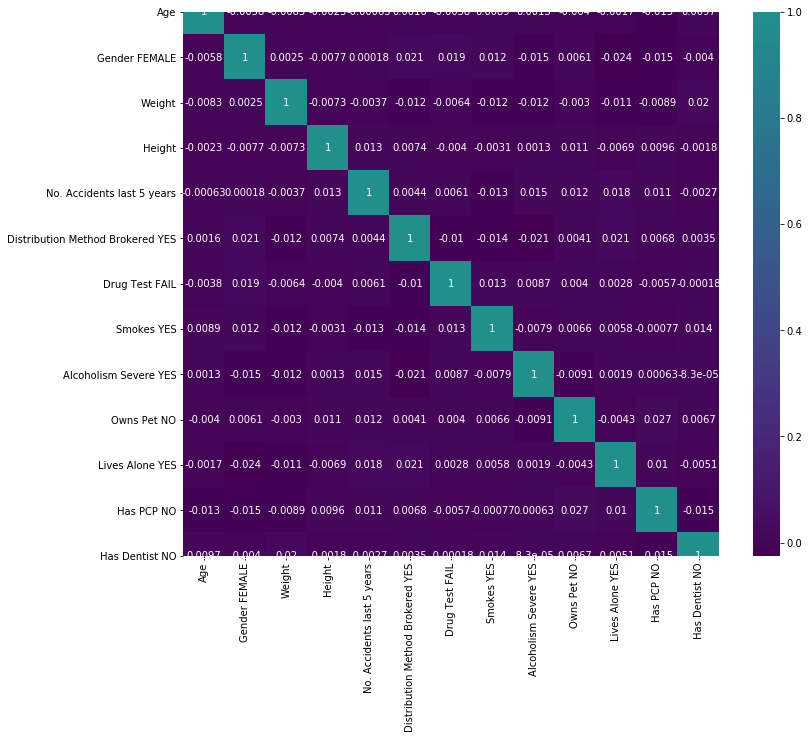

In [6]:
# correlations between auxiliary variables
correlations = Policies.corr()
fig = plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='viridis', center=1)

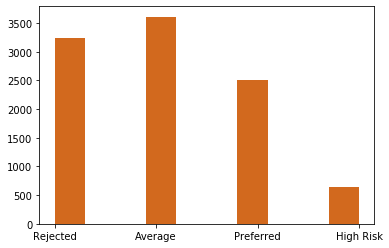

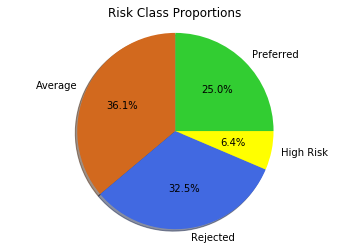

In [7]:
plt.hist(riskclass, color = 'chocolate')
labels = ["Average", "Rejected", "High Risk","Preferred"]
sizes = []
for x in labels:
    i = 0
    for y in riskclass:
        if y == x:
            i += 1
    sizes.append(i / len(riskclass))
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90,
        colors = ["chocolate","royalblue","yellow","limegreen"])
ax1.axis('equal')
ax1.set_title('Risk Class Proportions')
plt.show()

In [8]:
#sns.pairplot(Policies[Policies.columns[2:]])

## Model Creation

In [9]:
## user item interactions
interactions = Policies[Policies.columns[:2]]

In [10]:
## auxiliary features of the insureds
item_features = Policies[Policies.columns[1:]]

In [11]:
## fitting the model
model = RankFM(factors=20, loss='warp', max_samples=20, alpha= .01, sigma=0.1,
               learning_rate=0.01, learning_schedule='invscaling')
model.fit(interactions=interactions, item_features = item_features ,epochs=20, verbose=True)


training epoch: 0
log likelihood: -5701.06005859375

training epoch: 1
log likelihood: -5028.91015625

training epoch: 2
log likelihood: -4805.330078125

training epoch: 3
log likelihood: -4559.990234375

training epoch: 4
log likelihood: -4408.580078125

training epoch: 5
log likelihood: -4244.81005859375

training epoch: 6
log likelihood: -4072.0400390625

training epoch: 7
log likelihood: -3954.110107421875

training epoch: 8
log likelihood: -3854.85009765625

training epoch: 9
log likelihood: -3725.2900390625

training epoch: 10
log likelihood: -3625.0

training epoch: 11
log likelihood: -3517.280029296875

training epoch: 12
log likelihood: -3415.889892578125

training epoch: 13
log likelihood: -3327.429931640625

training epoch: 14
log likelihood: -3245.570068359375

training epoch: 15
log likelihood: -3183.570068359375

training epoch: 16
log likelihood: -3127.139892578125

training epoch: 17
log likelihood: -3076.199951171875

training epoch: 18
log likelihood: -3009.260009765

## Model Evaluation

In [19]:
## metrics
model_hrt = hit_rate(model,interactions,k=10)
model_pre = precision(model,interactions, k=2500)
model_rec = recall(model, interactions, k=2500)
model_F1 = 2*model_rec*model_pre / (model_rec + model_pre)
print("-"*20)
print("Hit Rate: ", "{:.4f}".format(model_hrt))
print("-"*20)
print("Precision:", "{:.4f}".format(model_pre))
print("-"*20)
print("Recall:   ", "{:.4f}".format(model_rec))
print("-"*20)
print("F1 Score: ", "{:.4f}".format(model_F1))
print("-"*20)

--------------------
Hit Rate:  0.7500
--------------------
Precision: 0.7770
--------------------
Recall:    0.7226
--------------------
F1 Score:  0.7488
--------------------


In [13]:
## top 5 recommendations for each risk class
model.recommend(np.unique(riskclass), n_items=5, filter_previous=True, cold_start='drop')

,0,1,2,3,4
Average,97536,99740,94653,94482,95990
High Risk,101377,100122,99002,101785,96356
Preferred,98335,95240,100221,94441,101859
Rejected,95238,93899,95605,92690,94362


In [14]:
## similar insureds to the first entry in the dataset
model.similar_items("95238", n_items=5)

array(['100122', '96506', '94722', '101377', '101974'], dtype=object)

In [15]:
model.recommend(["Preferred","Average","High Risk"], n_items=5, filter_previous=True, cold_start='drop')

,0,1,2,3,4
Preferred,98335,95240,100221,94441,101859
Average,97536,99740,94653,94482,95990
High Risk,101377,100122,99002,101785,96356


In [16]:
model.recommend(["Rejected"], n_items=5, filter_previous=True, cold_start='drop')

,0,1,2,3,4
Rejected,95238,93899,95605,92690,94362


In [17]:
b = 1000
e = 6000
model_pre = []
model_rec = []
#for k in range(b, e + 1):
#    model_pre.append(precision(model,interactions, k))
#    model_rec.append(recall(model, interactions, k))

In [18]:
#plt.plot([k for k in range(b,e + 1)], model_pre, color = "red")
#plt.plot([k for k in range(b,e + 1)], model_rec, color = "green")
#plt.legend(["Precision", "Recall"])
#plt.title("Precision and Recall Against Number of Recommended Items", loc = "left")